In [10]:
import re
import os
import gc
import sys
import torch
import random
import logging
import argparse
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import deeplab.network as network
import torchvision.transforms.functional as FUNC

from PIL import Image
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchmetrics import JaccardIndex, AveragePrecision

In [11]:
from torchvision.transforms import RandomCrop
from torch.utils.data import Dataset

class RandomCropSync:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        # Ottieni i parametri per il ritaglio casuale
        i, j, h, w = RandomCrop.get_params(img, output_size=self.size)
        # Applica il ritaglio sia all'immagine che alla maschera
        img = FUNC.crop(img, i, j, h, w)
        mask = FUNC.crop(mask, i, j, h, w)
        return img, mask

class RandomCropResizeSync:
    def __init__(self, size, min_crop_size=(128, 128), aspect_ratio_range=(0.5, 2.0)):
        """
        Inizializza il Random Crop con controlli sulle dimensioni minime e il range di aspect ratio,
        seguito da un Resize fisso.
        :param size: Tuple con la dimensione finale del resize (width, height).
        :param min_crop_size: Tuple con le dimensioni minime del crop (min_width, min_height).
        :param aspect_ratio_range: Tuple con il range valido di rapporto (width / height).
        """
        self.size = size
        self.min_crop_size = min_crop_size
        self.aspect_ratio_range = aspect_ratio_range

    def __call__(self, img, mask):
        # Ottieni dimensioni originali dell'immagine
        img_width, img_height = img.size
        min_width, min_height = self.min_crop_size
        min_aspect, max_aspect = self.aspect_ratio_range

        # TODO: sarebbe meglio togliere il for
        # Genera dimensioni valide per il crop
        for _ in range(10):  # Tentativi per trovare un crop valido
            crop_width = random.randint(min_width, img_width)
            crop_height = random.randint(min_height, img_height)

            # Calcola il rapporto tra larghezza e altezza
            aspect_ratio_min = min(crop_width / crop_height, crop_height / crop_width)
            aspect_ratio_max = 1 / aspect_ratio_min

            # Verifica che il rapporto sia nel range specificato
            if min_aspect <= aspect_ratio_min and aspect_ratio_max <= max_aspect:
                break
        else:
            # Se non trova un crop valido, usa l'intera immagine
            crop_width, crop_height = img_width, img_height

        # Genera coordinate valide per il crop
        i = random.randint(0, img_height - crop_height)
        j = random.randint(0, img_width - crop_width)

        # Applica il crop casuale all'immagine e alla maschera
        img = FUNC.crop(img, i, j, crop_height, crop_width)
        mask = FUNC.crop(mask, i, j, crop_height, crop_width)

        # Applica il resize fisso all'immagine e alla maschera
        img = FUNC.resize(img, self.size)
        mask = FUNC.resize(mask, self.size, interpolation=FUNC.InterpolationMode.NEAREST)

        return img, mask

class RandomHorizontalFlipSync:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            img = FUNC.hflip(img)
            mask = FUNC.hflip(mask)
        return img, mask
    
class ToTensorSync:
    def __call__(self, img, mask):
        # Converti l'immagine in un tensore normalizzato
        img_tensor = FUNC.to_tensor(img)
        
        # Converti la maschera in un tensore grezzo senza normalizzazione
        mask_tensor = FUNC.pil_to_tensor(mask)
        
        return img_tensor, mask_tensor
    
class NormalizeSync:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img, mask):
        img = FUNC.normalize(img, mean=self.mean, std=self.std)
        return img, mask
        
class ComposeSync:
    """
    Composizione di trasformazioni che accettano immagine e maschera.
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask):
        for transform in self.transforms:
            img, mask = transform(img, mask)
        return img, mask

class RandomResizeSync:
    def __init__(self, scale_range=(0.5, 1.5)):
        """
        Inizializza il resize dinamico sincronizzato.
        :param scale_range: Tuple contenente il range di scaling (min_scale, max_scale).
        """
        self.scale_range = scale_range

    def __call__(self, img, mask):
        # Scegli un fattore di scala casuale nell'intervallo specificato
        scale = random.uniform(*self.scale_range)
        
        # Calcola la nuova dimensione dell'immagine e della maschera
        new_width = int(img.width * scale)
        new_height = int(img.height * scale)
        
        # Applica il resize sia all'immagine che alla maschera
        img = FUNC.resize(img, (new_height, new_width))
        mask = FUNC.resize(mask, (new_height, new_width), interpolation=FUNC.InterpolationMode.NEAREST)
        
        return img, mask

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transforms=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms:
            image, mask = self.transforms(image, mask)

        mask = mask.squeeze()
        mask = mask.type(torch.int64)-1

        return image, mask


In [12]:
path_test = './data/test'
path_test_images            =  path_test + '/images/test/t5'
path_test_masks             =  path_test + '/annotations/test/t5'
path_test_anomaly_images    =  path_test + '/images/test/t6'
path_test_anomaly_masks     =  path_test + '/annotations/test/t6'

# Trasformazioni
transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training dataset
dataset_test = SegmentationDataset(
    images_dir = path_test_images,
    masks_dir = path_test_masks,
    transforms = transforms
)

# Validation dataset
dataset_test_anomaly = SegmentationDataset(
    images_dir = path_test_anomaly_images,
    masks_dir = path_test_anomaly_masks,
    transforms = transforms
)

In [232]:
device = 'cuda:0'

model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=21, output_stride=16)
model.classifier.classifier[3] = nn.Conv2d(256,13,1,1)

path = '/home/piecestola/space/ML4CV/results_4/train_0'
state_dict = torch.load(os.path.join(path,'ckpts/weights_mIoU_1.pt'), map_location=device)
model.load_state_dict(state_dict['model_state_dict'])

model.eval()

model.to(device)
print()

In [42]:
import torch
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

def calculate_mean_aupr(dataset, model, score_function, num_images, device):
    """
    Calcola la media degli AUPR per le prime `num_images` immagini di un dataset.

    Parameters:
        dataset: torch.utils.data.Dataset
            Il dataset contenente immagini e maschere.
        model: torch.nn.Module
            Il modello per calcolare le feature.
        score_function: Callable
            Funzione che prende le feature e restituisce lo score.
        num_images: int
            Numero di immagini su cui calcolare l'AUPR.
        device: torch.device
            Il dispositivo su cui eseguire il modello.

    Returns:
        float: La media degli AUPR calcolati sulle prime `num_images` immagini.
    """
    auprs = []  # Lista per salvare l'AUPR di ogni immagine

    for i in range(num_images):
        # Carica immagine e maschera
        image, mask = dataset[i]

        # Calcola le feature utilizzando il modello
        features = model(image.unsqueeze(dim=0).to(device)).cpu().squeeze()

        # Applica la funzione di score
        score = score_function(features)

        # Converti maschera in label
        label = (mask == 13).type(torch.int64)

        # Calcola precisione, richiamo e soglie
        precision, recall, _ = precision_recall_curve(label.flatten().detach().cpu().numpy(),
                                                      score.flatten().detach().cpu().numpy())

        # Calcola AUPR per l'immagine corrente
        aupr = auc(recall, precision)
        auprs.append(aupr)

    # Calcola la media degli AUPR
    return np.mean(auprs)

def calculate_aupr(dataset, model, score_function, num_images, device):
    """
    Calcola l'AUPR per le prime `num_images` immagini di un dataset.

    Parameters:
        dataset: torch.utils.data.Dataset
            Il dataset contenente immagini e maschere.
        model: torch.nn.Module
            Il modello per calcolare le feature.
        score_function: Callable
            Funzione che prende le feature e restituisce lo score.
        num_images: int
            Numero di immagini su cui calcolare l'AUPR.
        device: torch.device
            Il dispositivo su cui eseguire il modello.

    Returns:
        float: Il valore di AUPR calcolato sulle prime `num_images` immagini.
    """
    all_scores = []
    all_labels = []

    for i in range(num_images):
        # Carica immagine e maschera
        image, mask = dataset[i]
        
        # Calcola le feature utilizzando il modello
        features = model(image.unsqueeze(dim=0).to(device)).cpu().squeeze()

        # Applica la funzione di score
        score = score_function(features)
        
        # Converti maschera in label
        label = (mask == 13).type(torch.int64)

        # Accumula score e label
        all_scores.append(score.flatten().detach().cpu().numpy())
        all_labels.append(label.flatten().detach().cpu().numpy())

    # Converti le liste di numpy arrays in un singolo numpy array
    all_scores = np.concatenate(all_scores)
    all_labels = np.concatenate(all_labels)

    # Calcola precisione, richiamo e soglie
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)

    # Calcola AUPR
    return auc(recall, precision)

def visualize_score(dataset, model, score_function, index, device):
    """
    Visualizza lo score e i label di un'immagine del dataset.

    Parameters:
        dataset: torch.utils.data.Dataset
            Il dataset contenente immagini e maschere.
        model: torch.nn.Module
            Il modello per calcolare le feature.
        score_function: Callable
            Funzione che prende le feature e restituisce lo score.
        index: int
            L'indice dell'immagine da visualizzare.
        device: torch.device
            Il dispositivo su cui eseguire il modello.

    Returns:
        None
    """
    # Carica immagine e maschera
    image, mask = dataset[index]

    # Calcola le feature utilizzando il modello
    features = model(image.unsqueeze(dim=0).to(device)).cpu().squeeze()

    # Applica la funzione di score
    score = score_function(features).detach().cpu().numpy()

    # Converti maschera in label
    label = (mask == 13).type(torch.int64).detach().cpu().numpy()

    # Visualizza score e label
    plt.figure(figsize=(12, 6))

    # Score
    plt.subplot(1, 2, 1)
    plt.imshow(score, cmap='viridis')
    plt.title('Score')
    plt.colorbar()

    # Label
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')
    plt.title('Label')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Maxmium Softmax Probability
$$ \mathrm{score}(x) = -\max_{c}{\mathrm{softmax}(f(x))_c} $$

In [15]:
def MaxSoftmaxProbability(features:torch.Tensor):
    score, _ = torch.max(torch.softmax(features,dim=0),dim=0)
    return -score

MEAN AUPR: 0.15552248903240834
AUPR: 0.14299022371343287


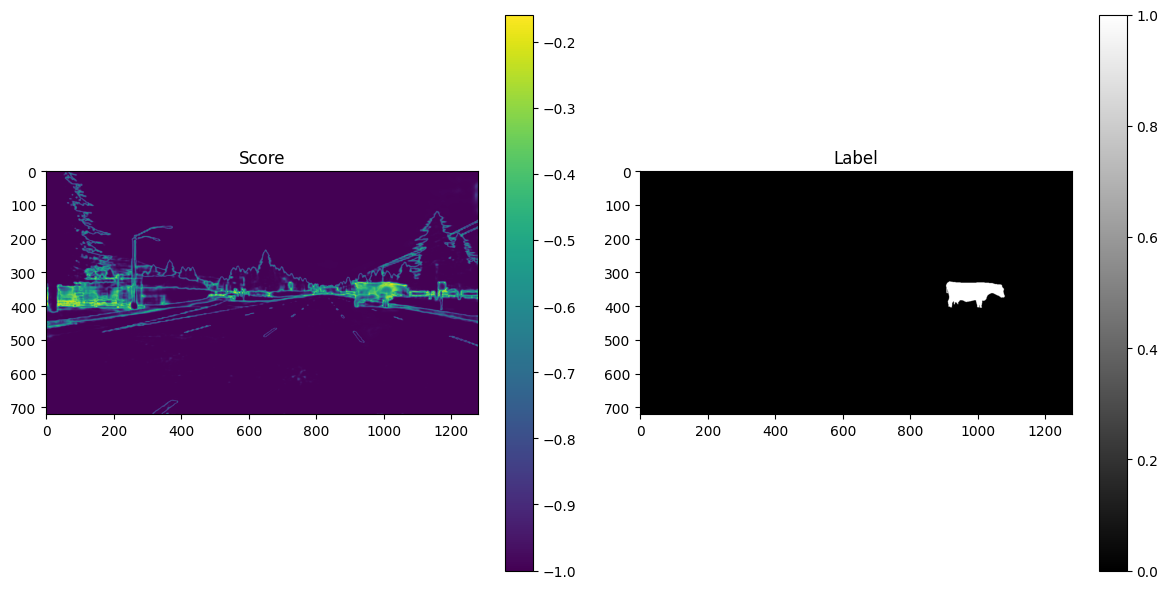

In [44]:
mean_aupr = calculate_mean_aupr(dataset_test_anomaly, model, MaxSoftmaxProbability, 50, device)
aupr = calculate_aupr(dataset_test_anomaly, model, MaxSoftmaxProbability, 50, device)
print("MEAN AUPR:",mean_aupr)
print("AUPR:",aupr)

visualize_score(dataset_test_anomaly, model, MaxSoftmaxProbability, 0, device)

# Maxmium Logit Score
$$ \mathrm{score}(x) = -\max_{c}{f(x)_c} $$

In [45]:
def MaxSLogitScore(features:torch.Tensor):
    score, _ = torch.max(features,dim=0)
    return -score

MEAN AUPR: 0.20660443970185616
AUPR: 0.21582319065139519


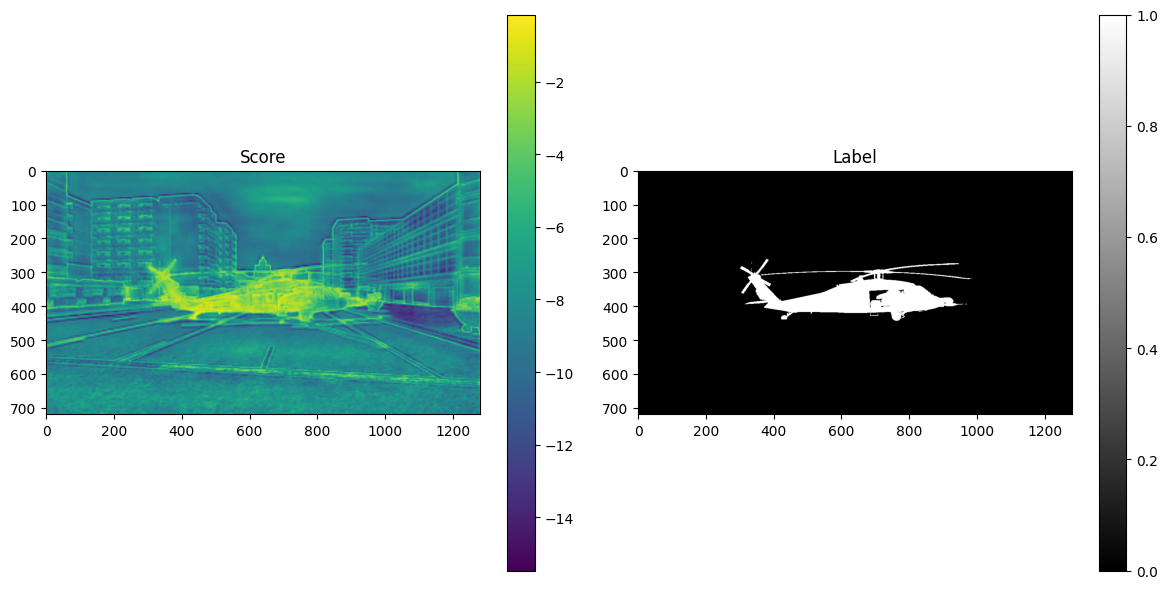

In [46]:
mean_aupr = calculate_mean_aupr(dataset_test_anomaly, model, MaxSLogitScore, 50, device)
aupr = calculate_aupr(dataset_test_anomaly, model, MaxSLogitScore, 50, device)
print("MEAN AUPR:",mean_aupr)
print("AUPR:",aupr)

visualize_score(dataset_test_anomaly, model, MaxSLogitScore, 0, device)

# Entropy Score
$$ \mathrm{score}(x) = \mathrm{entropy}{(\mathrm{softmax}(f(x)))} $$

In [47]:
def entropy_score(features:torch.Tensor):
    probs = torch.softmax(features,dim=0).clamp(min=1e-12)
    return - torch.sum(probs * torch.log(probs), dim=0)

MEAN AUPR: 0.20492041588538115
AUPR: 0.18853709836029328


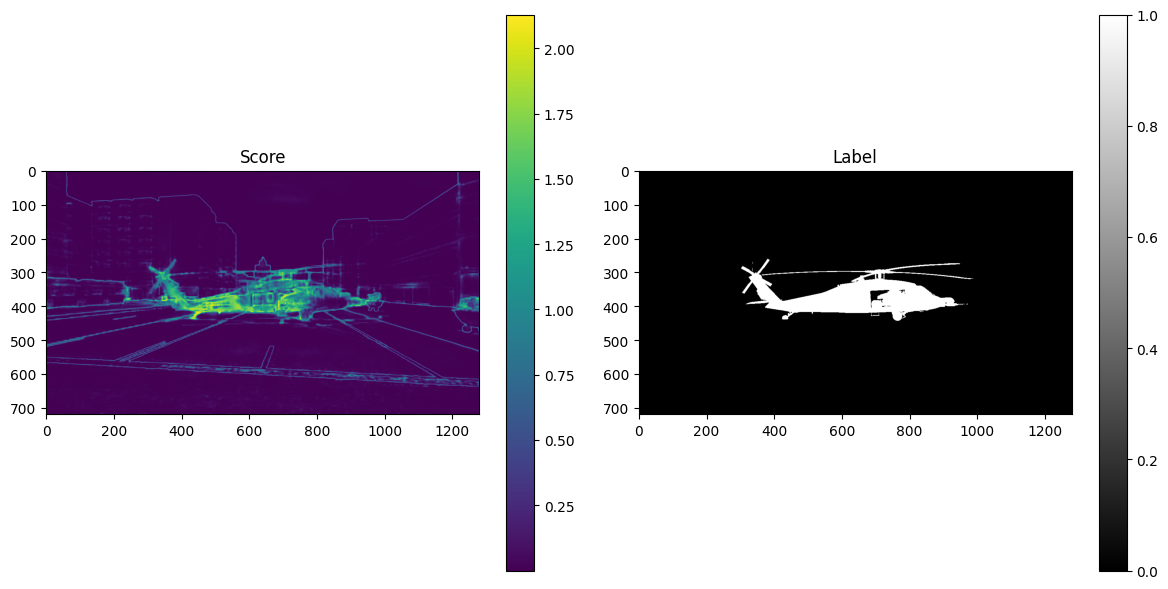

In [48]:
mean_aupr = calculate_mean_aupr(dataset_test_anomaly, model, entropy_score, 50, device)
aupr = calculate_aupr(dataset_test_anomaly, model, entropy_score, 50, device)
print("MEAN AUPR:",mean_aupr)
print("AUPR:",aupr)

visualize_score(dataset_test_anomaly, model, entropy_score, 0, device)

# Energy Score

In [49]:
def energy_score(logits: torch.Tensor):
    return -torch.logsumexp(logits, dim=0)

MEAN AUPR: 0.20501297683592934
AUPR: 0.2323672779246812


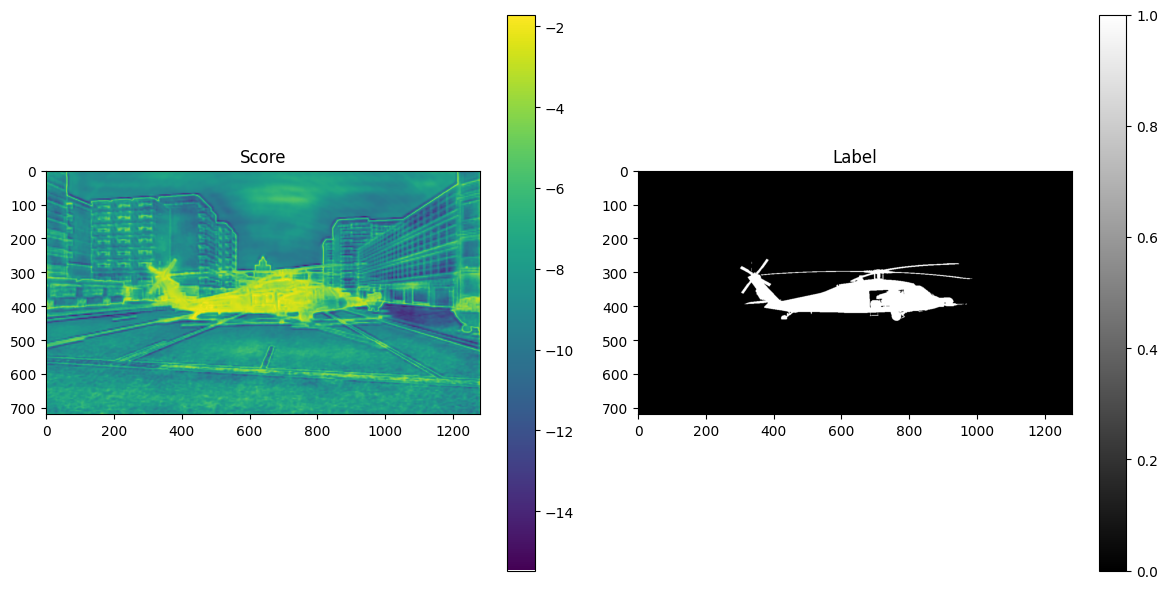

In [50]:
mean_aupr = calculate_mean_aupr(dataset_test_anomaly, model, energy_score, 50, device)
aupr = calculate_aupr(dataset_test_anomaly, model, energy_score, 50, device)
print("MEAN AUPR:",mean_aupr)
print("AUPR:",aupr)

visualize_score(dataset_test_anomaly, model, energy_score, 0, device)

# ODIN

In [51]:
def odin_score(model, image, T=1000, epsilon=0.001, device="cuda"):
    """
    Calcola lo score ODIN per un'immagine.

    Parameters:
        model: torch.nn.Module
            Il modello usato per l'inferenza.
        image: torch.Tensor
            L'immagine di input.
        T: float
            Fattore di temperatura per lo scaling.
        epsilon: float
            Ampiezza della perturbazione.
        device: torch.device
            Il dispositivo su cui eseguire il calcolo.

    Returns:
        torch.Tensor: Lo score ODIN.
    """
    image = image.to(device)
    image.requires_grad = True

    # Forward pass
    logits = model(image.unsqueeze(dim=0))
    probs = torch.softmax(logits / T, dim=1)

    # Perturb input
    max_class = torch.argmax(probs, dim=1)
    loss = torch.nn.CrossEntropyLoss()(logits, max_class)
    loss.backward()

    perturbed_image = image + epsilon * torch.sign(image.grad)
    logits = model(perturbed_image.unsqueeze(dim=0))
    probs = torch.softmax(logits / T, dim=1)

    return -torch.max(probs, dim=1)[0].squeeze()

def calculate_aupr_with_odin(dataset, model, num_images, device, T=1000, epsilon=0.001):
    """
    Calcola l'AUPR usando ODIN come score.

    Parameters:
        dataset: torch.utils.data.Dataset
            Il dataset contenente immagini e maschere.
        model: torch.nn.Module
            Il modello usato per l'inferenza.
        num_images: int
            Numero di immagini su cui calcolare l'AUPR.
        device: torch.device
            Il dispositivo su cui eseguire il calcolo.
        T: float
            Fattore di temperatura per lo scaling.
        epsilon: float
            Ampiezza della perturbazione.

    Returns:
        float: Il valore di AUPR calcolato.
    """
    all_scores = []
    all_labels = []

    for i in range(num_images):
        # Carica immagine e maschera
        image, mask = dataset[i]

        # Calcola lo score ODIN
        score = odin_score(model, image, T=T, epsilon=epsilon, device=device)

        # Converti maschera in label
        label = (mask == 13).type(torch.int64)

        # Accumula score e label
        all_scores.append(score.flatten().detach().cpu().numpy())
        all_labels.append(label.flatten().detach().cpu().numpy())

    # Converti le liste di numpy arrays in un singolo numpy array
    all_scores = np.concatenate(all_scores)
    all_labels = np.concatenate(all_labels)

    # Calcola precisione, richiamo e soglie
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)

    # Calcola AUPR
    return auc(recall, precision)

In [54]:
aupr = calculate_aupr_with_odin(dataset_test_anomaly, model, 50, device)
print("AUPR:",aupr)

AUPR: 0.22180398382751013


# MC Dropout

In [182]:
def enable_dropout(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout) or isinstance(module, torch.nn.Dropout2d):
            module.train()

def mc_dropout_score(model, image, num_passes=50, device="cuda"):
    image = image.to(device)
    outputs = []
    for _ in range(num_passes):
        outputs.append(model(image).squeeze().detach().cpu())
    outputs = torch.stack(outputs)
    variance, _ = torch.min(outputs.var(dim=0).squeeze(),dim=0)
    return variance

def calculate_aupr_with_mc_dropout(dataset, model, num_images, device, num_passes=50):
    all_scores = []
    all_labels = []
    model.eval()
    model.classifier.classifier.insert(3, nn.Dropout2d(p=0.5))
    enable_dropout(model)
    for i in range(num_images):
        image, mask = dataset[i]
        score = mc_dropout_score(model, image.unsqueeze(dim=0), num_passes=num_passes, device=device)
        label = (mask == 13).type(torch.int64)
        all_scores.append(score.flatten().numpy())
        all_labels.append(label.flatten().numpy())
    model.classifier.classifier.pop(3)
    all_scores = np.concatenate(all_scores)
    all_labels = np.concatenate(all_labels)
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    return auc(recall, precision)


In [188]:
if isinstance(model.classifier.classifier[3],nn.Dropout):
    model.classifier.classifier.pop(3)

In [189]:
aupr = calculate_aupr_with_mc_dropout(dataset_test_anomaly, model, 10, device, num_passes=2)
print("AUPR:",aupr)

AUPR: 0.019526297115031104


# Mahalanobis

In [305]:
import torch
import numpy as np

def compute_mahalanobis_statistics(model, dataloader, device="cuda"):
    model.eval()
    temp = model.classifier.classifier.pop(3)
    
    num_classes = 13
    feature_dim = 256
    
    # Inizializza media, conteggio e covarianza
    mean = torch.zeros((num_classes, feature_dim))
    count = torch.zeros(num_classes)
    covariance = torch.zeros((feature_dim, feature_dim))
    total_count = 0
    
    # Primo passaggio: Calcola la media
    with torch.no_grad():
        for j, (images, mask) in enumerate(dataloader):
            images = images.to(device)
            features = model(images).permute((1, 0, 2, 3)).cpu()  # (c, b, w, h)
            mask = mask.cpu()
            
            for i in range(num_classes):
                class_mask = (mask == i)
                class_features = features[:, class_mask]  # (c, n_pixels_in_class)
                
                if class_features.size(1) > 0:
                    mean[i] += class_features.sum(dim=1)  # Somma delle feature
                    count[i] += class_features.size(1)    # Conta i pixel della classe
            if j == 10:
                break

    # Normalizza la media
    for i in range(num_classes):
        if count[i] > 0:
            mean[i] /= count[i]

    # Secondo passaggio: Calcola la covarianza
    with torch.no_grad():
        for j, (images, mask) in enumerate(dataloader):
            images = images.to(device)
            features = model(images).permute((1, 0, 2, 3)).cpu()  # (c, b, w, h)
            mask = mask.cpu()
            
            for i in range(num_classes):
                class_mask = (mask == i)
                class_features = features[:, class_mask]  # (c, n_pixels_in_class)
                
                if class_features.size(1) > 0:
                    total_count += class_features.size(1)
                    centered_features = class_features.T - mean[i]  # Centra rispetto alla media
                    covariance += centered_features.T @ centered_features  # Aggiorna la covarianza
            if j == 10:
                break

    # Dividi per il numero totale di pixel e aggiungi regularizzazione
    covariance /= total_count
    covariance += 1e-6 * torch.eye(feature_dim)
    
    model.classifier.classifier.insert(3, temp)
    return {"mean": mean, "covariance": covariance}


def mahalanobis_distance(feature, mean, cov_inv):
    """
    Calcola la distanza di Mahalanobis tra una feature e una distribuzione.
    """
    diff = feature - mean
    dist = torch.sqrt(diff.T @ cov_inv @ diff)
    return dist

def mahalanobis_score(model, image, feature_layer, class_stats, device="cuda"):
    """
    Calcola lo score di Mahalanobis per ogni pixel di un'immagine.
    
    Parameters:
        model: torch.nn.Module
            Il modello di deep learning.
        image: torch.Tensor
            L'immagine di input.
        feature_layer: Callable
            Una funzione che estrae le feature dal modello.
        class_stats: dict
            Media e matrice di covarianza inversa per ogni classe.
        device: torch.device
            Il dispositivo su cui eseguire i calcoli.
    
    Returns:
        torch.Tensor: Lo score Mahalanobis per ogni pixel.
    """
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        features = feature_layer(model, image.unsqueeze(0))  # (1, feature_dim, w, h)
        features = features.squeeze(0).permute(1, 2, 0)  # (w, h, feature_dim)

        scores = torch.zeros(features.size(0), features.size(1), device=device)
        for cls, stats in class_stats.items():
            mean, cov_inv = stats["mean"], stats["cov_inv"]
            for i in range(features.size(0)):
                for j in range(features.size(1)):
                    feature = features[i, j]
                    dist = mahalanobis_distance(feature, mean, cov_inv)
                    scores[i, j] = max(scores[i, j], dist)

        return scores


In [292]:
# region DATASET
path_train = './data/train'
path_train_images =  path_train + '/images/training/t1-3'
path_valid_images =  path_train + '/images/validation/t4'
path_train_masks  =  path_train + '/annotations/training/t1-3'
path_valid_masks  =  path_train + '/annotations/validation/t4'

train_transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training dataset
dataset_train = SegmentationDataset(
    images_dir = path_train_images,
    masks_dir = path_train_masks,
    transforms = train_transforms
)

# Dataloader
num_workers = 2
train_batch_size = 4

dataloader_train = DataLoader(dataset_train,
                            batch_size=train_batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            drop_last=True)

In [299]:
device = 'cuda:0'

model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=21, output_stride=16)
model.classifier.classifier[3] = nn.Conv2d(256,13,1,1)

path = '/home/piecestola/space/ML4CV/results_4/train_0'
state_dict = torch.load(os.path.join(path,'ckpts/weights_mIoU_1.pt'), map_location=device)
model.load_state_dict(state_dict['model_state_dict'])

model.eval()

model.to(device)
print()

In [306]:
class_stats = compute_mahalanobis_statistics(model, dataloader_train, device)